In [14]:
import os
from timeit import default_timer as timer
from datetime import datetime, timedelta, date
from glob import glob
from pathlib import Path
import pandas as pd
import numpy as np
import itertools
from collections import Counter
import multiprocessing as mp
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns

/share/apps/anaconda3/2019.10/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
path_to_data='/scratch/spf248/covid/data'
start_date='01/01/2020'
end_date='04/16/2020'
source='cuebiq'
country='ID'
admin_id='ADM4_PCODE'
freq='W'

# Compute Origin Destination

In [ ]:
def get_env_var(varname,default):
    
    if os.environ.get(varname) != None:
        var = int(os.environ.get(varname))
        print(varname,':', var)
    else:
        var = default
        print(varname,':', var,'(Default)')
    return var

# Choose Number of Nodes To Distribute Credentials: e.g. jobarray=0-4, cpu_per_task=20, credentials = 90 (<100)
SLURM_JOB_ID            = get_env_var('SLURM_JOB_ID',0)
SLURM_ARRAY_TASK_ID     = get_env_var('SLURM_ARRAY_TASK_ID',0)
SLURM_ARRAY_TASK_COUNT  = get_env_var('SLURM_ARRAY_TASK_COUNT',1)
SLURM_JOB_CPUS_PER_NODE = get_env_var('SLURM_JOB_CPUS_PER_NODE',mp.cpu_count())

In [ ]:
print('Import')
start = timer()
data_dirs=glob(os.path.join(path_to_data,source,'processed',country,'pings_geocoded','*'))
pings_geocoded=pd.concat(
    pd.read_parquet(parquet_file)
    for data_dir in data_dirs for parquet_file in Path(data_dir).glob('*.parquet')
)
print("Done in", round(timer()-start), "sec")

In [ ]:
print('Process')
start = timer()
pings_geocoded.sort_values(by=['cuebiq_id','time'],inplace=True)
pings_geocoded.drop(['latitude','longitude','classification_type','accuracy'],1,inplace=True)
print("Done in", round(timer()-start), "sec")

In [ ]:
pings_geocoded.head()

In [ ]:
print('List trips')
start = timer()
trips=pings_geocoded.groupby([pd.Grouper(key='time',freq=freq),'cuebiq_id'])[admin_id].apply(list).to_frame()
trips.reset_index(drop=True,level='cuebiq_id',inplace=True)
trips=trips.truncate(before=start_date,after=end_date)
print("Done in", round(timer()-start), "sec")

In [ ]:
print('Count trips')
start=timer()
def count_trips(x):
    return Counter(itertools.combinations(x,2))
with mp.Pool(processes=SLURM_JOB_CPUS_PER_NODE) as pool:
    trips['trips_counter']=pool.map(count_trips, trips[admin_id])
print("Done in", round(timer()-start), "sec")

In [ ]:
print('Reshape')
start=timer()
def reshape_counters(x):
    return list(x.items())
with mp.Pool(processes=SLURM_JOB_CPUS_PER_NODE) as pool:
    trips['trips_list']=pool.map(reshape_counters, trips['trips_counter'])
trips=trips['trips_list'].explode().dropna()
trips=pd.DataFrame([*trips.values],index=trips.index,columns=['OD','n_trips'])
print("Done in", round(timer()-start), "sec")

In [ ]:
print('Aggregate')
start=timer()
trips=trips.groupby(['time','OD'])['n_trips'].sum().to_frame().reset_index()
trips=trips.join(pd.DataFrame([*trips['OD']], index=trips.index, columns=['origin','destination'])).drop('OD',1)
trips=trips.sort_values(by=['time','origin','destination']).set_index(['time','origin','destination'])['n_trips']
print("Done in", round(timer()-start), "sec")

In [ ]:
print('Save')
start = timer()
trips.to_csv(os.path.join(path_to_data,source,'processed',country,'origin_destination_'+freq+'.csv'))
print("Done in", round(timer()-start), "sec")

# Figures

In [195]:
def next_weekday(d, weekday):
    days_ahead = weekday - d.weekday()
    if days_ahead <= 0: # Target day already happened this week
        days_ahead += 7
    return d + timedelta(days_ahead)

In [69]:
city_id='UC_NM_MN'
city_name='Jakarta'
admin_agg='ADM2_EN'
final_date=next_weekday(date(datetime.today().year, datetime.today().month,1),6)
initial_date=next_weekday(date(datetime.today().year, datetime.today().month-2,1),6)

In [62]:
print('Load admin data')
start=timer()
admin=gpd.read_file(os.path.join(path_to_data,'admin',country,'admin.geojson'))
admin2city=pd.read_excel(os.path.join(path_to_data,'admin',country,'city2adminGHSL.xlsx'))[[city_id,admin_id]].drop_duplicates(admin_id)
print("Done in", round(timer()-start), "sec")  

Load admin data
Done in 79 sec


In [100]:
print('Load trips')
start=timer()
trips=pd.read_csv(os.path.join(path_to_data,source,'processed',country,'origin_destination_'+freq+'.csv'),index_col=[0,1,2],squeeze=True)
print("Done in", round(timer()-start), "sec")

Load trips
Done in 177 sec


In [101]:
print('Spatial Aggregation')
start=timer()
trips=trips.to_frame().reset_index()
trips['date']=pd.to_datetime(trips['date'])
trips.rename(columns={'origin':admin_id+'_origin','destination':admin_id+'_destination','time':'date'},inplace=True)
trips=trips.merge(
admin2city.loc[admin2city[city_id]==city_name,[admin_id]].rename(columns={admin_id:admin_id+'_origin'})).merge(
admin2city.loc[admin2city[city_id]==city_name,[admin_id]].rename(columns={admin_id:admin_id+'_destination'}))
trips=trips.merge(
admin[[admin_id,admin_agg]].rename(columns=lambda x:x+'_origin')).merge(
admin[[admin_id,admin_agg]].rename(columns=lambda x:x+'_destination'))
trips=trips.groupby(['date',admin_agg+'_origin',admin_agg+'_destination'])['n_trips'].sum()
admin_order=trips.groupby(admin_agg+'_origin').sum().sort_values(ascending=False)
trips=trips[trips.index.get_level_values(admin_agg+'_origin')!=\
trips.index.get_level_values(admin_agg+'_destination')].copy()
print("Done in",round(timer()-start),"sec") 

Spatial Aggregation
Done in 78 sec


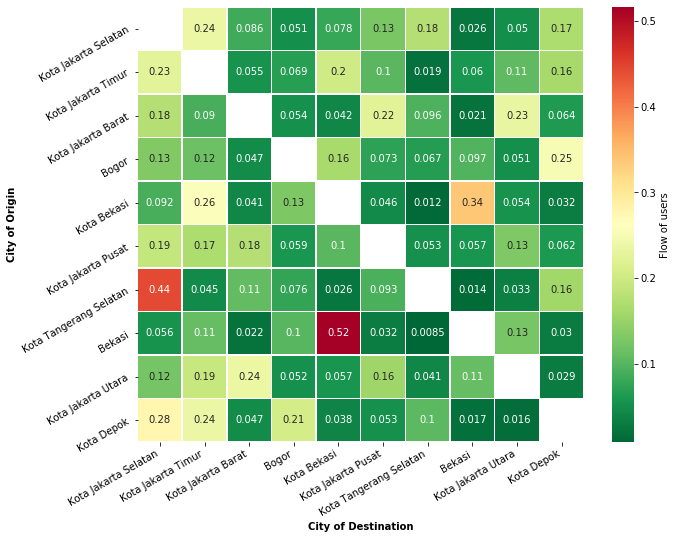

In [192]:
fig,ax=plt.subplots(figsize=(10,8))
df=trips.xs(final_date,level='date').unstack().loc[admin_order.index[:10]][admin_order.index[:10]].divide(
trips.xs(final_date,level='date').unstack().loc[admin_order.index[:10]][admin_order.index[:10]].sum(1),axis='rows')
mask=df.isnull()
sns.heatmap(df,mask=mask,cmap='RdYlGn_r', linewidths=0.5, annot=True, cbar_kws={'label': 'Flow of users'})
ax.set_xlabel('City of Destination',fontweight='bold')
ax.set_ylabel('City of Origin',fontweight='bold')
ax.set_xticklabels(ax.get_yticklabels(), rotation = 30, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 30, ha='right')
plt.savefig(os.path.join(path_to_data+'/../fig',country,'flows-'+city_name+'.pdf'),bbox_inches='tight')

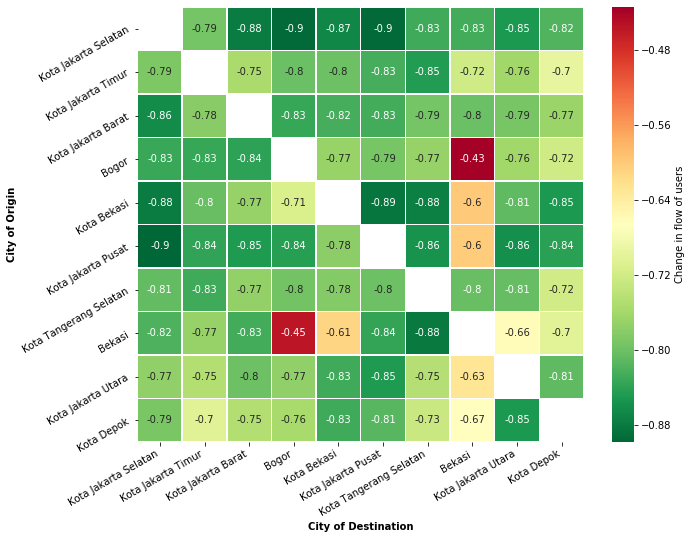

In [194]:
fig,ax=plt.subplots(figsize=(10,8))
df=trips.xs(final_date,level='date').unstack().loc[admin_order.index[:10]][admin_order.index[:10]].divide(
trips.xs(initial_date,level='date').unstack().loc[admin_order.index[:10]][admin_order.index[:10]])-1
mask=df.isnull()
sns.heatmap(df,mask=mask,cmap='RdYlGn_r', linewidths=0.5, annot=True, cbar_kws={'label': 'Change in flow of users'})
ax.set_xlabel('City of Destination',fontweight='bold')
ax.set_ylabel('City of Origin',fontweight='bold')
ax.set_xticklabels(ax.get_yticklabels(), rotation = 30, ha='right')
ax.set_yticklabels(ax.get_yticklabels(), rotation = 30, ha='right')
plt.savefig(os.path.join(path_to_data+'/../fig',country,'flow-changes-'+city_name+'.pdf'),bbox_inches='tight')